本文将采用 `Inception-ResNet-v2` 模型 完成58个类别的接近6K张交通标志图像的识别，重点是了解 `Inception-ResNet-v2` 模型的结构及其搭建方法。

# 一、前期工作

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1NMwgF0Qux5T4MCNYQo21dQ （提取码：x9ap）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL,pathlib

# 设置随机种子尽可能使结果可以重现
import pandas as pd
import numpy  as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

In [3]:
# 导入图片数据
pictures_dir = "D:/jupyter notebook/DL-100-days/datasets/14_traffic_sign/images"
pictures_dir = pathlib.Path(pictures_dir)

# 导入训练数据的图片路径名及标签
train = pd.read_csv("D:/jupyter notebook/DL-100-days/datasets/14_traffic_sign/annotations.csv")

## 3. 查看数据

In [4]:
image_count = len(list(pictures_dir.glob('*.png')))

print("图片总数为：",image_count)

图片总数为： 5998


In [5]:
train.head()

,file_name,category
0,000_0001.png,0
1,000_0002.png,0
2,000_0003.png,0
3,000_0010.png,0
4,000_0011.png,0


# 二、构建一个tf.data.Dataset

## 1.加载数据

数据集中已经划分好了测试集与训练集，这次只需要进行分别加载就好了。

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)  # 编码解码处理
    image = tf.image.resize(image, [299,299])        # 图片调整
    return image/255.0                               # 归一化处理

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
common_paths = "D:/jupyter notebook/DL-100-days/datasets/14_traffic_sign/images/"

# 训练数据的标签
train_image_label = [i for i in train["category"]]
train_label_ds = tf.data.Dataset.from_tensor_slices(train_image_label)

# 训练数据的路径
train_image_paths = [ common_paths+i for i in train["file_name"]]
# 加载图片路径
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
# 加载图片数据
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [8]:
# 将图片与标签进行对应打包
image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
image_label_ds

<ZipDataset shapes: ((299, 299, 3), ()), types: (tf.float32, tf.int32)>

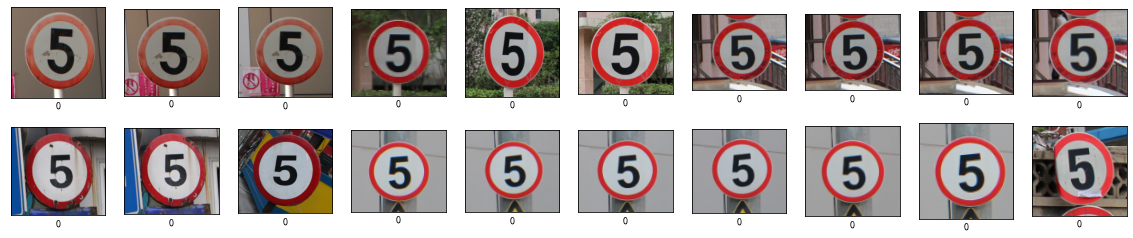

In [9]:
plt.figure(figsize=(20,4))

for i in range(20):
    plt.subplot(2,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # 显示图片
    images = plt.imread(train_image_paths[i])
    plt.imshow(images)
    # 显示标签
    plt.xlabel(train_image_label[i])

plt.show()

## 2. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

我的电脑GPU配置是 `NVIDIA GeForce RTX 3080` ,`BATCH_SIZE = 8`显存就会报OOM显存不足的错误，在`BATCH_SIZE = 6`时运行正常，每一个epoch时间约为130秒，大家请根据自己的电脑配置动态调整 `BATCH_SIZE`。采用CPU训练的同学，我建议将 `BATCH_SIZE` 调整为2或者1。

In [10]:
BATCH_SIZE = 6

# 将训练数据集拆分成训练集与验证集
train_ds = image_label_ds.take(5000).shuffle(1000)  # 前1500个batch
val_ds   = image_label_ds.skip(5000).shuffle(1000)  # 跳过前1500，选取后面的

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
# 查看数据 shape 进行检查
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(6, 299, 299, 3)
(6,)


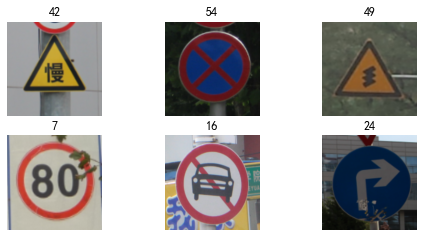

In [12]:
# 再次查看数据，确认是否被打乱
plt.figure(figsize=(8,8))

for images, labels in train_ds.take(1):
    for i in range(6):
        
        ax = plt.subplot(4, 3, i + 1)  
        plt.imshow(images[i])
        plt.title(labels[i].numpy())  #使用.numpy()将张量转换为 NumPy 数组
        
        plt.axis("off")

# 三、Inception-ResNet-v2介绍

关于Inception系列的介绍可以见：https://baike.baidu.com/item/Inception%E7%BB%93%E6%9E%84 ，个人认为这些在现阶段只需要将模型走一遍（学会搭建），后期如果需要的话，可以再回头来进行详细研究。

这个模型相比之前写过的一些模型可能较为复杂一些，先放一张图整体感受一下它

![](pictures/14-1.png)

关于上面卷积的计算还比较蒙的同学可以参考我这篇文章哈：[卷积的计算](https://blog.csdn.net/qq_38251616/article/details/114278995)

# 四、构建Inception-ResNet-v2网络

## 1.自己搭建

下面是本文的重点 `InceptionResNetV2` 网络模型的构建，可以试着按照上面的图自己构建一下 `InceptionResNetV2`，这部分我主要是参考官网的构建过程，将其单独拎了出来。

In [13]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout,BatchNormalization,Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Concatenate, Lambda,GlobalAveragePooling2D
from tensorflow.keras import backend as K

def conv2d_bn(x,filters,kernel_size,strides=1,padding='same',activation='relu',use_bias=False,name=None):
    
    x = Conv2D(filters,kernel_size,strides=strides,padding=padding,use_bias=use_bias,name=name)(x)
    
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = None if name is None else name + '_bn'
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = None if name is None else name + '_ac'
        x = Activation(activation, name=ac_name)(x)
    return x

def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    if block_type == 'block35':
        branch_0 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(branch_1, 32, 3)
        branch_2 = conv2d_bn(x, 32, 1)
        branch_2 = conv2d_bn(branch_2, 48, 3)
        branch_2 = conv2d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 128, 1)
        branch_1 = conv2d_bn(branch_1, 160, [1, 7])
        branch_1 = conv2d_bn(branch_1, 192, [7, 1])
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(branch_1, 224, [1, 3])
        branch_1 = conv2d_bn(branch_1, 256, [3, 1])
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: ' + str(block_type))

    block_name = block_type + '_' + str(block_idx)
    mixed = Concatenate(name=block_name + '_mixed')(branches)
    up = conv2d_bn(mixed,K.int_shape(x)[3],1,activation=None,use_bias=True,name=block_name + '_conv')

    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name=block_name + '_ac')(x)
    return x


def InceptionResNetV2(input_shape=[299,299,3],classes=1000):

    inputs = Input(shape=input_shape)

    # Stem block
    x = conv2d_bn(inputs, 32, 3, strides=2, padding='valid')
    x = conv2d_bn(x, 32, 3, padding='valid')
    x = conv2d_bn(x, 64, 3)
    x = MaxPooling2D(3, strides=2)(x)
    x = conv2d_bn(x, 80, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, padding='valid')
    x = MaxPooling2D(3, strides=2)(x)

    # Mixed 5b (Inception-A block)
    branch_0 = conv2d_bn(x, 96, 1)
    branch_1 = conv2d_bn(x, 48, 1)
    branch_1 = conv2d_bn(branch_1, 64, 5)
    branch_2 = conv2d_bn(x, 64, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_pool = AveragePooling2D(3, strides=1, padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1)
    branches = [branch_0, branch_1, branch_2, branch_pool]

    x = Concatenate(name='mixed_5b')(branches)

    # 10次 Inception-ResNet-A block
    for block_idx in range(1, 11):
        x = inception_resnet_block(x, scale=0.17, block_type='block35', block_idx=block_idx)

    # Reduction-A block
    branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='valid')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 256, 3)
    branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='valid')
    branch_pool = MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(name='mixed_6a')(branches)

    # 20次 Inception-ResNet-B block
    for block_idx in range(1, 21):
        x = inception_resnet_block(x, scale=0.1, block_type='block17', block_idx=block_idx)


    # Reduction-B block
    branch_0 = conv2d_bn(x, 256, 1)
    branch_0 = conv2d_bn(branch_0, 384, 3, strides=2, padding='valid')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 288, 3, strides=2, padding='valid')
    branch_2 = conv2d_bn(x, 256, 1)
    branch_2 = conv2d_bn(branch_2, 288, 3)
    branch_2 = conv2d_bn(branch_2, 320, 3, strides=2, padding='valid')
    branch_pool = MaxPooling2D(3, strides=2, padding='valid')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(name='mixed_7a')(branches)

    # 10次 Inception-ResNet-C block
    for block_idx in range(1, 10):
        x = inception_resnet_block(x, scale=0.2, block_type='block8', block_idx=block_idx)
    x = inception_resnet_block(x, scale=1., activation=None, block_type='block8', block_idx=10)


    x = conv2d_bn(x, 1536, 1, name='conv_7b')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    # 创建模型
    model = Model(inputs, x, name='inception_resnet_v2')

    return model

model = InceptionResNetV2([299,299,3],58)
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

## 2.官方模型

In [14]:
# import tensorflow as tf
# # 如果使用官方模型需要将图片shape调整为 [299,299,3]，目前图片的shape是 [150,150,3]
# model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2()
# model.summary()

# 五、设置动态学习率

这里先罗列一下学习率大与学习率小的优缺点。

- 学习率大
    - 优点：
        1、加快学习速率。
        2、有助于跳出局部最优值。
    - 缺点：
        1、导致模型训练不收敛。
        2、单单使用大学习率容易导致模型不精确。

- 学习率小
    - 优点：
        1、有助于模型收敛、模型细化。
        2、提高模型精度。
    - 缺点：
        1、很难跳出局部最优值。
        2、收敛缓慢。

注意：这里设置的动态学习率为：指数衰减型（ExponentialDecay）。在每一个epoch开始前，学习率（learning_rate）都将会重置为初始学习率（initial_learning_rate），然后再重新开始衰减。计算公式如下：

>learning_rate = initial_learning_rate * decay_rate ^ (step / decay_steps)

In [15]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=100,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,  # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 六、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [16]:
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 七、训练模型

`Inception-ResNet-v2` 模型相对之前的模型较为复杂，故而运行耗时也更长，我这边每一个epoch运行时间是130s左右。我的GPU配置是 `NVIDIA GeForce RTX 3080`。建议大家先将 `epochs` 调整为1跑通程序。

In [17]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
834/834 [==============================] - 154s 163ms/step - loss: 2.5214 - accuracy: 0.3563 - val_loss: 1.3834 - val_accuracy: 0.6168
Epoch 2/10
834/834 [==============================] - 133s 159ms/step - loss: 0.9230 - accuracy: 0.7522 - val_loss: 0.5457 - val_accuracy: 0.8531
Epoch 3/10
834/834 [==============================] - 133s 159ms/step - loss: 0.3952 - accuracy: 0.9105 - val_loss: 0.3391 - val_accuracy: 0.9064
Epoch 4/10
834/834 [==============================] - 134s 160ms/step - loss: 0.1876 - accuracy: 0.9655 - val_loss: 0.2481 - val_accuracy: 0.9296
Epoch 5/10
834/834 [==============================] - 131s 156ms/step - loss: 0.1071 - accuracy: 0.9862 - val_loss: 0.1265 - val_accuracy: 0.9716
Epoch 6/10
834/834 [==============================] - 128s 153ms/step - loss: 0.0587 - accuracy: 0.9954 - val_loss: 0.0911 - val_accuracy: 0.9794
Epoch 7/10
834/834 [==============================] - 132s 158ms/step - loss: 0.0429 - accuracy: 0.9976 - val_loss: 0.0941 -

# 八、模型评估

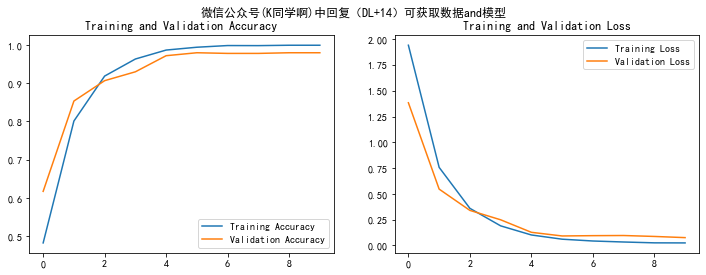

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.suptitle("微信公众号(K同学啊)中回复（DL+14）可获取数据and模型")

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 九、模型的保存与加载

In [19]:
# 保存模型
model.save('model/14_model.h5')

In [20]:
# 加载模型
new_model = keras.models.load_model('model/14_model.h5')

# 十、预测

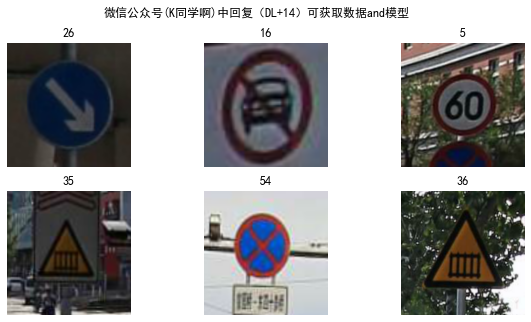

In [25]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("微信公众号(K同学啊)中回复（DL+14）可获取数据and模型")

for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)  
        
        # 显示图片
        plt.imshow(images[i])
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测路标
        predictions = new_model.predict(img_array)
        plt.title(np.argmax(predictions))

        plt.axis("off")

***

**推荐阅读：**

✨ [**深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天**](https://mtyjkh.blog.csdn.net/article/details/116920825) 

✨ [**深度学习100例 - 卷积神经网络（Inception V3）识别手语 | 第13天**](https://mtyjkh.blog.csdn.net/article/details/118310170)

✨ [**手把手教你用 CNN 识别验证码 - 深度学习100例 | 第12天**](https://mtyjkh.blog.csdn.net/article/details/118152545)

✨ [**循环神经网络（LSTM）实现股票预测-深度学习100例 | 第10天**](https://mtyjkh.blog.csdn.net/article/details/117907074)

✨ [**深度学习100例-卷积神经网络（VGG-16）识别海贼王草帽一伙 | 第6天**](https://mtyjkh.blog.csdn.net/article/details/117331631)


**🚀 来自专栏：[《深度学习100例》](https://blog.csdn.net/qq_38251616/category_11068756.html)**

**未完～**

**持续更新 欢迎 点赞👍、收藏⭐、关注👀**

- 点赞👍：点赞给我持续更新的动力
- 收藏⭐️：收藏后你能够随时找到文章
- 关注👀：关注我第一时间接收最新文章